### Coursework coding instructions (please also see full coursework spec)

Please choose if you want to do either Task 1 or Task 2. You should write your report about one task only.

For the task you choose you will need to do two approaches:
  - Approach 1, which can use use pre-trained embeddings / models
  - Approach 2, which should not use any pre-trained embeddings or models
We should be able to run both approaches from the same colab file

#### Running your code:
  - Your models should run automatically when running your colab file without further intervention
  - For each task you should automatically output the performance of both models
  - Your code should automatically download any libraries required

#### Structure of your code:
  - You are expected to use the 'train', 'eval' and 'model_performance' functions, although you may edit these as required
  - Otherwise there are no restrictions on what you can do in your code

#### Documentation:
  - You are expected to produce a .README file summarising how you have approached both tasks

#### Reproducibility:
  - Your .README file should explain how to replicate the different experiments mentioned in your report

Good luck! We are really looking forward to seeing your reports and your model code!

In [1]:
# You will need to download any word embeddings required for your code, e.g.:
# ! pip install sacremoses
# ! pip install transformers
# !wget http://nlp.stanford.edu/data/glove.6B.zip -P /vol/bitbucket/rp3317/data/
# !unzip /vol/bitbucket/rp3317/data/glove.6B.zip -d /vol/bitbucket/rp3317/data/


In [2]:
# For any packages that Colab does not provide auotmatically you will also need to install these below, e.g.:

# !pip install ipympl
#! pip install torch
# ! pip install swifter
# !wget https://cs.rochester.edu/u/nhossain/semeval-2020-task-7-dataset.zip -P data/
# !unzip data/semeval-2020-task-7-dataset.zip
# ! python -m spacy download en

In [12]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1n2iImmVxmV9FtrNx2Z4FyVJI6bPsCTTm' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1n2iImmVxmV9FtrNx2Z4FyVJI6bPsCTTm" -O newsdata.zip && rm -rf /tmp/cookies.txt
!unzip newsdata.zip

--2021-03-01 12:21:20--  https://docs.google.com/uc?export=download&confirm=L_US&id=1n2iImmVxmV9FtrNx2Z4FyVJI6bPsCTTm
Resolving docs.google.com (docs.google.com)... 2a00:1450:4009:817::200e, 172.217.169.14
Connecting to docs.google.com (docs.google.com)|2a00:1450:4009:817::200e|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-80-docs.googleusercontent.com/docs/securesc/1ibjbqmv2pnkirj6blrql7f5ftjp04cg/9rs149kpjsel6chmcn082f9bcf7401ko/1614601275000/16703018712613523847/08769474311849947251Z/1n2iImmVxmV9FtrNx2Z4FyVJI6bPsCTTm?e=download [following]
--2021-03-01 12:21:20--  https://doc-0o-80-docs.googleusercontent.com/docs/securesc/1ibjbqmv2pnkirj6blrql7f5ftjp04cg/9rs149kpjsel6chmcn082f9bcf7401ko/1614601275000/16703018712613523847/08769474311849947251Z/1n2iImmVxmV9FtrNx2Z4FyVJI6bPsCTTm?e=download
Resolving doc-0o-80-docs.googleusercontent.com (doc-0o-80-docs.googleusercontent.com)... 2a00:1450:4009:806::2001, 216.58.204.65
Connecting

In [516]:
# Imports

import torch
import torch.nn.functional as F
import re 
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import pandas as pd
import numpy as np
import string
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import Dataset, random_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import codecs
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
from tqdm.notebook import tqdm_notebook
from tqdm import tqdm
from collections import defaultdict
tqdm_notebook.pandas()


In [4]:
# Setting random seed and device
SEED = 1

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


In [5]:
# Load data
train_df = pd.read_csv('data/train.csv')
funlines_df = pd.read_csv('data/train_funlines.csv')
test_df = pd.read_csv('data/dev.csv')
news_df = pd.read_json('News_Category_Dataset_v2.json', lines=True)
all_headlines = list(train_df['original']) + list(funlines_df['original'])

embeddings_dict = {}
with open("/vol/bitbucket/rp3317/data/glove.6B.50d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

## Named Entity Recognition
Casing of headlines makes traditional NER harder, train a statistical true caser then give to bert uncased model / use spacy NER

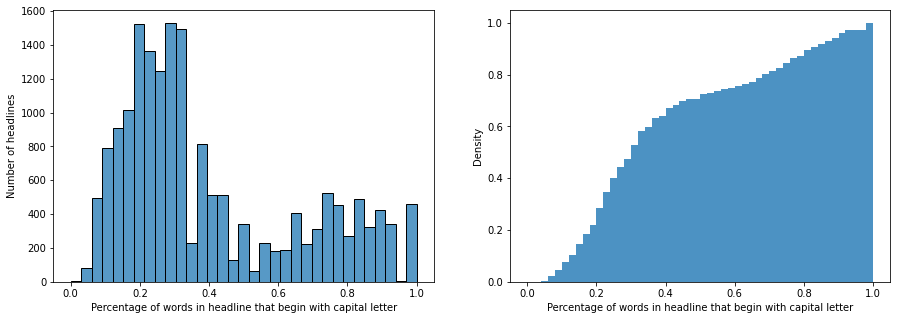

In [6]:
upperalpha = set('ABCDEFGHIJKLMNOPQRSTUVWXYZ')
punctuation = string.punctuation + "‘’”“’'/-\\."
hasCap = lambda x: (x[0] in upperalpha) or x[0].isdigit() if len(x) > 0 else False
def percentageCap(sentence):
    cleaned = re.sub(r"<(.*)\/>", "\g<1>", sentence).strip(punctuation).split(' ')
    return (len([w for w in cleaned if hasCap(w)]) / len(cleaned), ' '.join(cleaned))

cap_headlines = np.array([percentageCap(h) for h in all_headlines])
fig, ax =plt.subplots(1,2, figsize=(15,5))
caps = cap_headlines[:,0].astype(float)

sns.histplot(caps, ax=ax[0])
ax[0].set(xlabel='Percentage of words in headline that begin with capital letter', ylabel='Number of headlines')

ax[1].set_xlabel('Percentage of words in headline that begin with capital letter')
ax[1].set_ylabel('Density')
ax[1]=plt.hist(caps,cumulative=True, density=True, bins=50, alpha=0.8)
plt.show()

In [7]:
from sacremoses import MosesTruecaser, MosesTokenizer
headlines_less_than = lambda limit: cap_headlines[caps < limit][:,1] 
headlines_more_than = lambda limit: cap_headlines[caps > limit][:,1] 

mtr = MosesTruecaser()
mtok = MosesTokenizer(lang='en')
tokenized_docs = [mtok.tokenize(line) for line in headlines_less_than(0.45)]
truecase_results = mtr.train(tokenized_docs, save_to='big.truecasemodel')

In [8]:

def truecase(headline):
    s = mtr.truecase(headline.lower(), return_str=True)
    return s

truecase(np.random.choice(headlines_more_than(0.8)))

'Kellyanne Conway melts down under grilling by Fox news'

In [9]:
tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER-uncased")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER-uncased")
# ! python -m spacy download en_core_web_lg
# nlp = spacy.load('en_core_web_lg')


In [10]:
class EntityTagger:
    def __init__(self):
        self.nlp = pipeline("ner", model=model, tokenizer=tokenizer, device=0)
    
    def _next_word_is_connected(self, results, i):
        return (i < len(results) - 1) and \
                results[i+1]['word'].startswith('##') and \
                results[i]['end'] == results[i+1]['start'] \
        
    def _process_results(self, results):
        if not results:
            return []
        words = []
        cur_word = ""
        cur_start = results[0]['start']
        for i, r in enumerate(results):
            cur_word += re.sub("##(.*)", "\g<1>", r['word'])
            if not self._next_word_is_connected(results, i):
                words.append(dict(word=cur_word, type=r['entity'][2::], start=cur_start, end=r['end']))
                cur_word = ""
                cur_start = results[i+1]['start'] if i < len(results) - 1 else results[i]['start']
            
        return words
            
    def tag(self, text):
        results = self.nlp(text)
        return self._process_results(results)

tagger = EntityTagger()
# example = "Visa , Mastercard , Stripe , and eBay all quit Facebook ’s Libra in one day"
example = np.random.choice(headlines_more_than(0.7))
tagger.tag(example)

[{'word': 'pelosi', 'type': 'PER', 'start': 8, 'end': 14},
 {'word': 'trump', 'type': 'PER', 'start': 23, 'end': 28},
 {'word': 'state', 'type': 'ORG', 'start': 40, 'end': 45},
 {'word': 'union', 'type': 'ORG', 'start': 53, 'end': 58}]

In [128]:
import spacy
from spacy.lang.en import English
nlp = spacy.load('en_core_web_sm')
class PreProcessor():
    def __init__(self, remove_stops=False, lowercase=False, lemmatize=False, replace_edit=False):
        self.remove_stops = remove_stops
        self.lowercase = lowercase
        self.lemmatize = lemmatize
        self.replace_edit = replace_edit
    
    def process(self,row): 
        e, o = row['edit'], row['original']
        if self.replace_edit:
            replaced = re.sub(r"<(.*)\/>", r"\g<1>", row['original'])
        else:
            replaced = re.sub(r"<(.*)\/>", e, o)
        
        replaced = replaced.translate(str.maketrans('','', punctuation))
        if self.lowercase:
            replaced = replaced.lower()
        doc = nlp(replaced)
        doc = [t for t in doc if t.text not in punctuation]
        doc = [t for t in doc if not t.is_space] # Remove space tokens
        if self.remove_stops:
            doc = [t for t in doc if not (t.is_stop and t.text != e)] # Ensure edits aren't removed if they are stop words
        if self.lemmatize:
            st = " ".join([t.lemma_ for t in doc])
        else:
            st = " ".join([t.text for t in doc])
            
        return st
# PreProcessor(remove_stops=True, lowercase=True, lemmatize=True) \
#     .process(dict(original="Trump announces ' precision strikes ' on Syria , decries ' <monster/> ' Assad"))

In [12]:
import pickle
preprocessor = PreProcessor(remove_stops=False)
train_df['cleaned'] = train_df.progress_apply(preprocessor.process, axis=1)
train_df['entity_tags'] = train_df.progress_apply(lambda x: tagger.tag(x['cleaned']), axis=1)
with open("traindf.pkl", "wb") as f:
    pickle.dump(train_df, f)

  0%|          | 0/9652 [00:00<?, ?it/s]

  0%|          | 0/9652 [00:00<?, ?it/s]

In [461]:
def get_unique_entities(threshold=8):
    unique = defaultdict(lambda: defaultdict(int))
    for i, entities in enumerate(train_df['entity_tags']):
        for e in entities:
            unique[e['type']][e['word']] += 1
    
    thresholded = defaultdict(lambda: defaultdict(int))
    for k, v in unique.items():
        for ent, count in v.items():
            if count >= threshold:
                thresholded[k][ent] = count
    
    return thresholded
entities = get_unique_entities()

In [462]:
names = np.array(sorted(entities['PER'].items(), key=lambda x: x[1])[::-1])
counts = names[:,1].astype(int)
# for i, c in enumerate(counts):
#     print(f"{names[i][0]} - {c * 100 / sum(counts):.2f}%")
fig = plt.figure(figsize=(15,4))
plt.bar(names[:,0][2:30],counts[2:30])
fig.axes[0].tick_params(axis="x", labelsize=9)
fig.axes[0].tick_params(axis="y", labelsize=12)
fig.axes[0].set_xlabel("People")
fig.axes[0].set_ylabel("Occurences")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0, 0.5, 'Occurences')

In [463]:
train_df['cleaned_no_stops'] = train_df.progress_apply(PreProcessor(remove_stops=True, lowercase=True, lemmatize=True).process, axis=1)

  0%|          | 0/9652 [00:00<?, ?it/s]

In [464]:
train_df['cleaned_replaced'] = train_df.progress_apply(PreProcessor(remove_stops=True, lowercase=True, lemmatize=True, replace_edit=True).process, axis=1)

  0%|          | 0/9652 [00:00<?, ?it/s]

In [465]:
def all_entities():
    all_entities = set()
    for k in entities.keys():
        for e in entities[k]:
            all_entities.add(e)
    return all_entities

def getNearbyWords():
    nearby_words = defaultdict(set)
    counts = defaultdict(int)
    for i, w in tqdm(enumerate(train_df['cleaned_no_stops'])):
        tags = train_df.iloc[i]['entity_tags']
        edit = nlp(train_df.iloc[i]['edit'].lower())[0].lemma_
        ents_in_headline = set(tag['word'] for tag in tags)
        nearby = set(w.split(' ')) - ents_in_headline
        for w in ents_in_headline:
            for n in nearby:
                counts[(w,n)] += train_df.iloc[i]['meanGrade']**3
            nearby_words[w] |= nearby
        nearby_words[w].add(edit)
        counts[(w,edit)] += train_df.iloc[i]['meanGrade']**3
    return nearby_words, counts

all_entities = all_entities()
nearby_words, counts = getNearbyWords()

9652it [00:56, 169.53it/s]


In [466]:
%matplotlib widget

from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans

sns.set_style("whitegrid", {'axes.grid' : False})

def getEmbs(ent, three_dims=False, topn=20, plot=False):
    if ent not in nearby_words:
        print("Not valid ent")
        return
    words_to_plot = [w for w in nearby_words[ent] if w in embeddings_dict]
    if not words_to_plot:
        print("No words to plot")
        return
    words_to_plot = sorted(words_to_plot, key=lambda w: -counts[(ent, w)])[:topn]
    vectors = np.array([embeddings_dict[w] for w in words_to_plot])
    if plot:
        fig, ax = plt.subplots()
        points = PCA(random_state=0).fit_transform(vectors)[:,:3]

        if three_dims:
            ax = Axes3D(fig)
            ax.scatter(points[:,0], points[:,1], points[:,2])
            for i, txt in enumerate(words_to_plot):
                ax.text(points[i,0], points[i,1], points[i,2], txt)
        else:
            ax.scatter(points[:,0], points[:,1])
            for i, txt in enumerate(words_to_plot):
                ax.annotate(txt, (points[i,0], points[i,1]))
        plt.show()
    return words_to_plot, vectors
    

In [467]:
def getClusterVectors(ent, plot=False, n_clusters=3, topn=50):
    words, vectors = getEmbs(ent, topn=topn)
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(vectors)
    if plot:
        points = PCA(random_state=0).fit_transform(np.concatenate((vectors,kmeans.cluster_centers_)))[:,:3]
        cluster_colours = np.repeat(n_clusters, n_clusters)
        colours = np.concatenate((kmeans.labels_, cluster_colours))
        fig, ax = plt.subplots()
        ax.scatter(points[:,0], points[:,1], c=colours)
        for i, txt in enumerate(words + [f'CLUSTER {i+1}' for i in range(n_clusters)]):
            kwargs = {}
            if 'CLUSTER ' in txt:
                kwargs = {'weight': 'bold'}
            ax.annotate(txt, (points[i,0], points[i,1]), **kwargs)
        plt.show()
    return kmeans.cluster_centers_

entity_clusters = {ent: getClusterVectors(ent, n_clusters=2, topn=10) for ent in tqdm(all_entities)}


100%|██████████| 450/450 [00:05<00:00, 83.81it/s]


# Collect features

In [468]:

def position_of_edit(row):
    words = row['original'].split(' ')
    count = 0
    for w in words:
        if re.match("<.*\/>", w):
            return count
        count += 1
    return 1

def len_headline(row):
    return len(row['original'].split(' '))
    
def funniness_of_each_entity():
    funniness = defaultdict(float)
    counts = defaultdict(int)
    for i, ents in tqdm(enumerate(train_df['entity_tags'])):
        for ent in ents:
            funniness[ent['word']] += train_df.iloc[i]['meanGrade']
            counts[ent['word']] += 1
            
    avg_funniness = dict()
    for k, v in funniness.items():
        avg_funniness[k] = funniness[k] / counts[k]
    
    return avg_funniness
        
train_df['edit_pos'] = train_df.progress_apply(position_of_edit, axis=1)
train_df['len'] = train_df.progress_apply(len_headline, axis=1)

  0%|          | 0/9652 [00:00<?, ?it/s]

  0%|          | 0/9652 [00:00<?, ?it/s]

In [469]:
#  sorted(list(entity_funniness.items()), key=lambda x: -entity_funniness[x[0]])
entity_funniness = funniness_of_each_entity()

9652it [00:03, 3143.56it/s]


In [539]:
def similarity(a, b):
    return np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

def get_max_similarity(vec, clusters):
    return np.max([similarity(vec, c) for c in clusters])

def entity_funniness_score(row): 
    r = row['cleaned_replaced']
    relevant_entities = [x['word'] for x in row['entity_tags'] if (x['word'] in entity_funniness) and (x['word'] in entity_clusters)]
    score = 0
    for w in r.split(' '):
        if w not in embeddings_dict or w in relevant_entities:
            continue
        vec = embeddings_dict[w]
        for ent in relevant_entities:
#             if not (ent in entities['PER'] or ent in entities['LOC']):
#                 continue
            clusters = entity_clusters[ent]
            max_sim = get_max_similarity(vec, clusters)
            score += (max_sim ** 0.25) * entity_funniness[ent] ** 3
    return score
    
train_df['entity_funniness_score'] = train_df.progress_apply(entity_funniness_score, axis=1)
train_df['entity_funniness_score'].fillna(0, inplace=True)
fig, ax = plt.subplots()
ax.hist(train_df['entity_funniness_score'].to_numpy(), bins=52)
plt.show()
train_df['entity_funniness_score'].corr(train_df['meanGrade'])

  0%|          | 0/9652 [00:00<?, ?it/s]

<ipython-input-539-8049e178e731>:20: RuntimeWarning: invalid value encountered in power
  score += (max_sim ** 0.25) * entity_funniness[ent] ** 3


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

0.14481284300571423

In [500]:
def distance_of_edit_to_original(row):
#     return np.random.randint(100) * 0.01
    e = row['edit'].lower()
    original = re.search('<(.*)\/>', row['original']).group(1).lower()
    if original in embeddings_dict and e in embeddings_dict:
        return similarity(embeddings_dict[e], embeddings_dict[original])
    return 0

train_df['edit_similarity'] = train_df.progress_apply(distance_of_edit_to_original, axis=1)
fig, ax = plt.subplots()
ax.hist(train_df['edit_similarity'].to_numpy(), bins=52)
plt.show()
train_df['edit_similarity'].corr(train_df['meanGrade'])

  0%|          | 0/9652 [00:00<?, ?it/s]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

-0.15680708656808165

In [501]:
train_df.head()

,id,original,edit,grades,meanGrade,cleaned,entity_tags,cleaned_no_stops,edit_pos,len,cleaned_replaced,entity_funniness_score,edit_similarity
0,14530,France is ‘ hunting down its citizens who join...,twins,10000,0.2,France is hunting down its citizens who joined...,"[{'word': 'france', 'type': 'LOC', 'start': 0,...",france hunt citizen join twin trial iraq,9,15,france hunt citizen join isis trial iraq,6.842978,0.064800
1,13034,"Pentagon claims 2,000 % increase in Russian tr...",bowling,33110,1.6,Pentagon claims 2000 increase in Russian troll...,"[{'word': 'pentagon', 'type': 'ORG', 'start': ...",pentagon claim 2000 increase russian troll bow...,9,17,pentagon claim 2000 increase russian troll syr...,15.329575,-0.019825
2,8731,Iceland PM Calls Snap Vote as Pedophile Furor ...,party,22100,1.0,Iceland PM Calls Snap Vote as Pedophile Furor ...,"[{'word': 'iceland', 'type': 'LOC', 'start': 0...",iceland pm call snap vote pedophile furor cras...,9,11,iceland pm call snap vote pedophile furor cras...,0.000000,0.830763
3,76,"In an apparent first , Iran and Israel <engage...",slap,20000,0.4,In an apparent first Iran and Israel engage ea...,"[{'word': 'iran', 'type': 'LOC', 'start': 21, ...",apparent iran israel slap militarily,8,12,apparent iran israel engage militarily,3.352819,0.169812
4,6164,Trump was told weeks ago that Flynn misled <Vi...,school,0,0.0,Trump was told weeks ago that Flynn misled Vic...,"[{'word': 'trump', 'type': 'PER', 'start': 0, ...",trump tell week ago flynn mislead school presi...,8,11,trump tell week ago flynn mislead vice president,10.341708,0.384219


# Train neural net

In [563]:
test_df['cleaned'] = test_df.progress_apply(preprocessor.process, axis=1)
test_df['entity_tags'] = test_df.progress_apply(lambda x: tagger.tag(x['cleaned']), axis=1)
test_df['cleaned_no_stops'] = test_df.progress_apply(PreProcessor(remove_stops=True, lowercase=True, lemmatize=True).process, axis=1)
test_df['cleaned_replaced'] = test_df.progress_apply(PreProcessor(remove_stops=True, lowercase=True, lemmatize=True, replace_edit=True).process, axis=1)
test_df['entity_funniness_score'] = test_df.progress_apply(entity_funniness_score, axis=1)
test_df['entity_funniness_score'].fillna(0, inplace=True)

  0%|          | 0/2419 [00:00<?, ?it/s]

  0%|          | 0/2419 [00:00<?, ?it/s]

  0%|          | 0/2419 [00:00<?, ?it/s]

  0%|          | 0/2419 [00:00<?, ?it/s]

  0%|          | 0/2419 [00:00<?, ?it/s]

<ipython-input-539-8049e178e731>:20: RuntimeWarning: invalid value encountered in power
  score += (max_sim ** 0.25) * entity_funniness[ent] ** 3


In [561]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 100)  
        self.fc2 = nn.Linear(100, 100)  
        self.fc3 = nn.Linear(100, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x * 4

In [574]:
net = Net().to(device)
# cols = ['edit_pos', 'len', 'edit_similarity', 'entity_funniness_score']
cols = ['entity_funniness_score']
training_data, dev_data, training_y, dev_y = train_test_split(train_df[cols], train_df['meanGrade'], test_size=0.1, random_state=42)
train_X = torch.tensor(training_data.to_numpy()).float()
val_X = torch.tensor(dev_data.to_numpy()).float()
train_y = torch.tensor(training_y.to_numpy()).float()
val_y = torch.tensor(dev_y.to_numpy()).float()
test_X = torch.tensor(test_df[cols].to_numpy()).float()
test_y = torch.tensor(test_df['meanGrade'].to_numpy()).float()

train_ds = torch.utils.data.TensorDataset(train_X, train_y)
val_ds = torch.utils.data.TensorDataset(val_X, val_y)
test_ds = torch.utils.data.TensorDataset(test_X, test_y)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=8)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=8)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=8)

loss_fn = nn.MSELoss()
loss_fn = loss_fn.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

def train(epochs=20):
    train_losses = []
    val_losses = []
    for e in range(epochs):
        train_loss = 0
        for batch_idx, (X, y) in enumerate(train_loader):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            pred = net(X).squeeze(1)
            loss = loss_fn(pred, y)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
            
        with torch.no_grad():
            val_loss = 0
            for batch_idx, (X, y) in enumerate(test_loader):
                X, y = X.to(device), y.to(device)
                pred = net(X)
                loss = loss_fn(pred, y)
                val_loss += loss.item()
            vl = val_loss / len(test_loader)
            val_losses.append(vl)
            
        tl = train_loss / len(train_loader)
        train_losses.append(tl)
        print(f"Epoch {e:<3} - TL : {tl:.3f} | TRAIN RMSE: {np.sqrt(tl):.3f} | VL : {vl:.3f} | VAL RMSE : {np.sqrt(vl):.3f}")
    return train_losses, val_losses
tl, vl = train()

Epoch 0   - TL : 0.384 | TRAIN RMSE: 0.620 | VL : 0.341 | VAL RMSE : 0.584
Epoch 1   - TL : 0.352 | TRAIN RMSE: 0.593 | VL : 0.346 | VAL RMSE : 0.588
Epoch 2   - TL : 0.347 | TRAIN RMSE: 0.589 | VL : 0.343 | VAL RMSE : 0.586
Epoch 3   - TL : 0.343 | TRAIN RMSE: 0.586 | VL : 0.343 | VAL RMSE : 0.585
Epoch 4   - TL : 0.342 | TRAIN RMSE: 0.585 | VL : 0.342 | VAL RMSE : 0.585
Epoch 5   - TL : 0.341 | TRAIN RMSE: 0.584 | VL : 0.341 | VAL RMSE : 0.584
Epoch 6   - TL : 0.340 | TRAIN RMSE: 0.583 | VL : 0.341 | VAL RMSE : 0.584
Epoch 7   - TL : 0.339 | TRAIN RMSE: 0.582 | VL : 0.340 | VAL RMSE : 0.583
Epoch 8   - TL : 0.338 | TRAIN RMSE: 0.582 | VL : 0.340 | VAL RMSE : 0.583
Epoch 9   - TL : 0.338 | TRAIN RMSE: 0.581 | VL : 0.339 | VAL RMSE : 0.583
Epoch 10  - TL : 0.337 | TRAIN RMSE: 0.581 | VL : 0.339 | VAL RMSE : 0.582
Epoch 11  - TL : 0.337 | TRAIN RMSE: 0.580 | VL : 0.339 | VAL RMSE : 0.583
Epoch 12  - TL : 0.337 | TRAIN RMSE: 0.580 | VL : 0.339 | VAL RMSE : 0.582
Epoch 13  - TL : 0.337 | 

In [575]:
net.eval()
with torch.no_grad():
    test_loss = 0
    for batch_idx, (X, y) in enumerate(test_loader):
        X, y = X.to(device), y.to(device)
        pred = net(X)
        loss = loss_fn(pred, y)
        test_loss += loss.item()
    test_loss = test_loss / len(test_loader)

np.sqrt(test_loss)

0.5820224928055039

# Data exploration
- 0 - not funny
- 1 - slightly funny
- 2 - moderately funny
- 3 - very funny

In [ ]:
sns.histplot(train_df.meanGrade, kde=True, bins=24)

In [ ]:
# Number of people grading each example
sns.countplot(x="grades", data=pd.DataFrame(train_df.grades.apply(lambda x : len(str(x))), columns=['grades']))

In [89]:
def getExamplesForFunninessBetween(f1, f2):
    mg = train_df['meanGrade']
    return train_df[((mg < f2) & (mg > f1))]
def showSamples(n):
    for i in range(3):
        d = getExamplesForFunninessBetween(i, i+1).sample(n)
        for i in range(n):
            cell = d.iloc[i]
            print(f"{cell['meanGrade']} - {cell['edit']:>12} - {cell['original']}")

showSamples(3)

0.2 -     holidays - Virginia <clashes/> bring attention to anti-fascist movement
0.6 -     stealing - Wall Street 's top regulator is <resigning/> from the Fed
0.2 -     pressure - Former intelligence director Clapper rips Comey 's firing , says US government is ‘ under <assault/> ’
1.6 -      Dancing - Stop It — Trump Does n’t Do <Strategy/> 
1.8 -    custodian - This week InfoWars.com was offered White House <Press/> Credentials
1.6 -          gum - China says it will never allow war or <chaos/> on its doorstep
2.6 -      midlife - Chinese state media : Trump is ' wrong ' when he says we can fix the <North Korea/> crisis
2.6 -          hug - Trump Holds First <Conversation/> with Putin in Oval Office
2.4 -       sesame - Here 's how <Wall/> Street is reacting to Trump 's tax plan


# Preprocessing
- Replace words in original with edit
- Tokenise with spacy
- Remove punctuation symbols
- lowercase 
- Delete stop words

## Ideas
- Compare POS tag of old/new sentence
- Make a language model on news articles and check perplexity/probability of edit = https://www.kaggle.com/rmisra/news-category-dataset
- LDA model on real headlines - if its not part of the top 50 topics then probably out of domain
- Check probability of all n-gram pairs surrounding edit
- https://www.scribendi.ai/can-we-use-bert-as-a-language-model-to-assign-score-of-a-sentence/


In [ ]:
import re 
import string
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
nlp = English()

punctuation = set(string.punctuation + '‘’”“')
pd.set_option('display.max_colwidth', None)

def process(row): 
    e, o = row['edit'], row['original']
    replaced = re.sub(r"<.*\/>", e, o)
    doc = nlp(replaced)
    doc = [t for t in doc if t.text not in punctuation]
    doc = [t for t in doc if not (t.is_stop and t.text != e)] # Ensure edits aren't removed if they are stop words
    doc = [t for t in doc if not t.is_space] # Remove space tokens
    return doc

In [ ]:
train_df['edited'] = train_df.apply(process, axis=1)
train_df.head(10)['edited']

In [ ]:
# Number of epochs
epochs = 10

# Proportion of training data for train compared to dev
train_proportion = 0.8

In [ ]:
# We define our training loop
def train(train_iter, dev_iter, model, number_epoch):
    """
    Training loop for the model, which calls on eval to evaluate after each epoch
    """
    print("Training model.")
    for epoch in range(1, number_epoch+1):
        model.train()
        epoch_loss = 0
        epoch_sse = 0
        no_observations = 0  # Observations used for training so far

        for batch in train_iter:
            feature, target = batch
            feature, target = feature.to(device), target.to(device)

            # for RNN:
            model.batch_size = target.shape[0]
            no_observations = no_observations + target.shape[0]
            model.hidden = model.init_hidden()

            predictions = model(feature).squeeze(1)
            optimizer.zero_grad()
            loss = loss_fn(predictions, target)
            sse, __ = model_performance(predictions.detach().cpu().numpy(), target.detach().cpu().numpy())
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()*target.shape[0]
            epoch_sse += sse

        valid_loss, valid_mse, __, __ = eval(dev_iter, model)
        epoch_loss, epoch_mse = epoch_loss / no_observations, epoch_sse / no_observations
        print(f'| Epoch: {epoch:02} | Train Loss: {epoch_loss:.2f} | Train MSE: {epoch_mse:.2f} | Train RMSE: {epoch_mse**0.5:.2f} | \
        Val. Loss: {valid_loss:.2f} | Val. MSE: {valid_mse:.2f} |  Val. RMSE: {valid_mse**0.5:.2f} |')

In [ ]:
# We evaluate performance on our dev set
def eval(data_iter, model):
    """
    Evaluating model performance on the dev set
    """
    model.eval()
    epoch_loss = 0
    epoch_sse = 0
    pred_all = []
    trg_all = []
    no_observations = 0

    with torch.no_grad():
        for batch in data_iter:
            feature, target = batch

            feature, target = feature.to(device), target.to(device)

            # for RNN:
            model.batch_size = target.shape[0]
            no_observations = no_observations + target.shape[0]
            model.hidden = model.init_hidden()

            predictions = model(feature).squeeze(1)
            loss = loss_fn(predictions, target)

            # We get the mse
            pred, trg = predictions.detach().cpu().numpy(), target.detach().cpu().numpy()
            sse, __ = model_performance(pred, trg)

            epoch_loss += loss.item()*target.shape[0]
            epoch_sse += sse
            pred_all.extend(pred)
            trg_all.extend(trg)

    return epoch_loss/no_observations, epoch_sse/no_observations, np.array(pred_all), np.array(trg_all)

In [9]:
# How we print the model performance
def model_performance(output, target, print_output=False):
    """
    Returns SSE and MSE per batch (printing the MSE and the RMSE)
    """

    sq_error = (output - target)**2

    sse = np.sum(sq_error)
    mse = np.mean(sq_error)
    rmse = np.sqrt(mse)

    if print_output:
        print(f'| MSE: {mse:.2f} | RMSE: {rmse:.2f} |')

    return sse, mse

In [10]:
def create_vocab(data):
    """
    Creating a corpus of all the tokens used
    """
    tokenized_corpus = [] # Let us put the tokenized corpus in a list
    for sentence in data:
        tokenized_sentence = []
        for token in sentence.split(' '): # simplest split is
            tokenized_sentence.append(token)
        tokenized_corpus.append(tokenized_sentence)

    # Create single list of all vocabulary
    vocabulary = []  # Let us put all the tokens (mostly words) appearing in the vocabulary in a list
    for sentence in tokenized_corpus:
        for token in sentence:
            if token not in vocabulary:
                if True:
                    vocabulary.append(token)

    return vocabulary, tokenized_corpus

In [11]:
def collate_fn_padd(batch):
    '''
    We add padding to our minibatches and create tensors for our model
    '''

    batch_labels = [l for f, l in batch]
    batch_features = [f for f, l in batch]

    batch_features_len = [len(f) for f, l in batch]

    seq_tensor = torch.zeros((len(batch), max(batch_features_len))).long()
    for idx, (seq, seqlen) in enumerate(zip(batch_features, batch_features_len)):
        seq_tensor[idx, :seqlen] = torch.LongTensor(seq)
    batch_labels = torch.FloatTensor(batch_labels)

    return seq_tensor, batch_labels

class Task1Dataset(Dataset):

    def __init__(self, train_data, labels):
        self.x_train = train_data
        self.y_train = labels

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, item):
        return self.x_train[item], self.y_train[item]

In [12]:
class BiLSTM(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, batch_size, device):
        super(BiLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.device = device
        self.batch_size = batch_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2label = nn.Linear(hidden_dim * 2, 1)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly why they have this dimensionality.
        # The axes semantics are (num_layers * num_directions, minibatch_size, hidden_dim)
        return torch.zeros(2, self.batch_size, self.hidden_dim).to(self.device), \
               torch.zeros(2, self.batch_size, self.hidden_dim).to(self.device)

    def forward(self, sentence):
        embedded = self.embedding(sentence)
        embedded = embedded.permute(1, 0, 2)

        lstm_out, self.hidden = self.lstm(
            embedded.view(len(embedded), self.batch_size, self.embedding_dim), self.hidden)

        out = self.hidden2label(lstm_out[-1])
        return out

In [14]:
## Approach 1 code, using functions defined above:

# We set our training data and test data
training_data = train_df['original']
test_data = test_df['original']

# Creating word vectors
training_vocab, training_tokenized_corpus = create_vocab(training_data)
test_vocab, test_tokenized_corpus = create_vocab(test_data)

# Creating joint vocab from test and train:
joint_vocab, joint_tokenized_corpus = create_vocab(pd.concat([training_data, test_data]))

print("Vocab created.")

# We create representations for our tokens
wvecs = [] # word vectors
word2idx = [] # word2index
idx2word = []

# This is a large file, it will take a while to load in the memory!
glove_file = '/vol/bitbucket/rp3317/data/glove.6B.100d.txt'
with codecs.open(glove_file, 'r','utf-8') as f:
  index = 1
  for line in f.readlines():
    # Ignore the first line - first line typically contains vocab, dimensionality
    if len(line.strip().split()) > 3:
      word = line.strip().split()[0]
      if word in joint_vocab:
          (word, vec) = (word,
                     list(map(float,line.strip().split()[1:])))
          wvecs.append(vec)
          word2idx.append((word, index))
          idx2word.append((index, word))
          index += 1

wvecs = np.array(wvecs)
word2idx = dict(word2idx)
idx2word = dict(idx2word)

vectorized_seqs = [[word2idx[tok] for tok in seq if tok in word2idx] for seq in training_tokenized_corpus]

# To avoid any sentences being empty (if no words match to our word embeddings)
vectorized_seqs = [x if len(x) > 0 else [0] for x in vectorized_seqs]

INPUT_DIM = len(word2idx)
EMBEDDING_DIM = 100
BATCH_SIZE = 32

model = BiLSTM(EMBEDDING_DIM, 50, INPUT_DIM, BATCH_SIZE, device)
print("Model initialised.")

model.to(device)
# We provide the model with our embeddings
model.embedding.weight.data.copy_(torch.from_numpy(wvecs))

feature = vectorized_seqs

# 'feature' is a list of lists, each containing embedding IDs for word tokens
train_and_dev = Task1Dataset(feature, train_df['meanGrade'])

train_examples = round(len(train_and_dev)*train_proportion)
dev_examples = len(train_and_dev) - train_examples

train_dataset, dev_dataset = random_split(train_and_dev,
                                           (train_examples,
                                            dev_examples))

train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)
dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)

print("Dataloaders created.")

loss_fn = nn.MSELoss()
loss_fn = loss_fn.to(device)

optimizer = torch.optim.Adam(model.parameters())

train(train_loader, dev_loader, model, epochs)

Vocab created.
Model initialised.
Dataloaders created.
Training model.
| Epoch: 01 | Train Loss: 0.36 | Train MSE: 0.36 | Train RMSE: 0.60 |         Val. Loss: 0.34 | Val. MSE: 0.34 |  Val. RMSE: 0.58 |
| Epoch: 02 | Train Loss: 0.35 | Train MSE: 0.35 | Train RMSE: 0.59 |         Val. Loss: 0.34 | Val. MSE: 0.34 |  Val. RMSE: 0.58 |
| Epoch: 03 | Train Loss: 0.34 | Train MSE: 0.34 | Train RMSE: 0.59 |         Val. Loss: 0.34 | Val. MSE: 0.34 |  Val. RMSE: 0.58 |
| Epoch: 04 | Train Loss: 0.34 | Train MSE: 0.34 | Train RMSE: 0.58 |         Val. Loss: 0.34 | Val. MSE: 0.34 |  Val. RMSE: 0.58 |
| Epoch: 05 | Train Loss: 0.33 | Train MSE: 0.33 | Train RMSE: 0.58 |         Val. Loss: 0.34 | Val. MSE: 0.34 |  Val. RMSE: 0.58 |
| Epoch: 06 | Train Loss: 0.29 | Train MSE: 0.29 | Train RMSE: 0.54 |         Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.59 |
| Epoch: 07 | Train Loss: 0.26 | Train MSE: 0.26 | Train RMSE: 0.51 |         Val. Loss: 0.36 | Val. MSE: 0.36 |  Val. RMSE: 0.60 |
| Epo

#### Approach 2: No pre-trained representations

In [ ]:
train_and_dev = train_df['edit']

training_data, dev_data, training_y, dev_y = train_test_split(train_df['edit'], train_df['meanGrade'],
                                                                        test_size=(1-train_proportion),
                                                                        random_state=42)

# We train a Tf-idf model
count_vect = CountVectorizer(stop_words='english')
train_counts = count_vect.fit_transform(training_data)
transformer = TfidfTransformer().fit(train_counts)
train_counts = transformer.transform(train_counts)
regression_model = LinearRegression().fit(train_counts, training_y)

# Train predictions
predicted_train = regression_model.predict(train_counts)

# Calculate Tf-idf using train and dev, and validate model on dev:
test_and_test_counts = count_vect.transform(train_and_dev)
transformer = TfidfTransformer().fit(test_and_test_counts)

test_counts = count_vect.transform(dev_data)

test_counts = transformer.transform(test_counts)

# Dev predictions
predicted = regression_model.predict(test_counts)

# We run the evaluation:
print("\nTrain performance:")
sse, mse = model_performance(predicted_train, training_y, True)

print("\nDev performance:")
sse, mse = model_performance(predicted, dev_y, True)


Train performance:
| MSE: 0.13 | RMSE: 0.37 |

Dev performance:
| MSE: 0.36 | RMSE: 0.60 |


#### Baseline for task 2

In [ ]:
# Baseline for the task
pred_baseline = torch.zeros(len(dev_y)) + np.mean(training_y)
print("\nBaseline performance:")
sse, mse = model_performance(pred_baseline, dev_y, True)


Baseline performance:
| MSE: 0.34 | RMSE: 0.58 |
